# Team members: Aakriti Batra, Sai Tej Reddy, Sanika Vaidya, Vishal Khopkar
# Project: NLP Analysis of Continuous Glucose Monitoring (CGM) for Diabetes

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import warnings
import seaborn as sns
import nltk
from nltk.corpus import stopwords
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from nltk.corpus import wordnet
warnings.filterwarnings('ignore')

In [2]:
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\sanik\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sanik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sanik\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Loading the dataset

cols = ['Post ID', 'Sound Bite Text', 'Title', 'Sentiment', 'Post Type']
data = pd.read_excel(r"C:\Users\sanik\Downloads\Diabetes Continuous Glucose Monitoring – Data Export.xlsx")
data = pd.DataFrame(data,columns=cols)
data.columns = ['postID', 'text', 'title', 'sentiment', 'postType']

### Exploratory data analysis

In [8]:
data.head()

postID                                               text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4   BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   

                                               title  sentiment  \
0  Have you been denied a second/third pump? Feel...   Neutrals   
1                                          Metformin  Positives   
2                                                NaN  Positives   
3                                                NaN   Neutrals   
4                   No bath salts, bath oils, soaks?   Neutrals   

               postType  
0  Replies and Comments  
1  Replies and Comments  
2  Replies and Comments  
3              Original  
4  Replies and Comments

In [9]:
# Length of data
len(data)

37844

In [10]:
# Shape of data
data.shape

(37844, 5)

In [11]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37844 entries, 0 to 37843
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   postID     37844 non-null  object
 1   text       37844 non-null  object
 2   title      36273 non-null  object
 3   sentiment  37844 non-null  object
 4   postType   35165 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [12]:
# Checking null values
data.isnull().sum()

postID          0
text            0
title        1571
sentiment       0
postType     2679
dtype: int64

In [13]:
# 1571 rows have empty title.

In [14]:
# Number of unique sentiments
data['sentiment'].nunique()

4

In [15]:
# Unique sentiment values
data['sentiment'].unique()

array(['Neutrals', 'Positives', 'Mixed', 'Negatives'], dtype=object)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

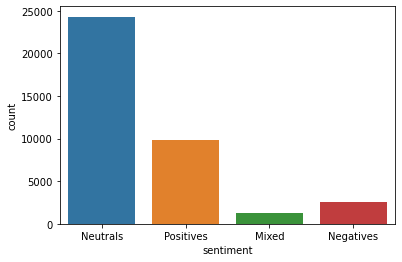

In [16]:
sns.countplot(x='sentiment', data=data)

In [17]:
data

postID                                               text  \
0       BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1       BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2      1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3        17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4       BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   
...                    ...                                                ...   
37839   BRDRDT2-t1_imokb3b  Push for it, it's a game changer in my opinion...   
37840   BRDRDT2-t1_imn2fob  (My mom learned to inject my 10 year old self ...   
37841   BRDRDT2-t1_imod0qi  I just spoke with a rep from Abbott. The rep t...   
37842    17865491111775314  It’s been 2.5 weeks since I started and I’m fe...   
37843   BRDRDT2-t1_imohltu  My first endo told me, paraphrasing, 'If you d...   

                                                   title  sentiment  \
0      Have you been denied a second/third pump? Feel...   Neutrals   
1                                              Metformin  Positives   
2                                                    NaN  Positives   
3                                                    NaN   Neutrals   
4                       No bath salts, bath oils, soaks?   Neutrals   
...                                                  ...        ...   
37839  If you were magically cured of type I diabetes...   Neutrals   
37840                A question for the older Diabetics.  Negatives   
37841                           Apple IOS 16 public beta   Neutrals   
37842                                                NaN   Neutrals   
37843                A question for the older Diabetics.   Neutrals   

                   postType  
0      Replies and Comments  
1      Replies and Comments  
2      Replies and Comments  
3                  Original  
4      Replies and Comments  
...                     ...  
37839  Replies and Comments  
37840  Replies and Comments  
37841  Replies and Comments  
37842              Original  
37843  Replies and Comments  

[37844 rows x 5 columns]

### We shall remove all those rows which do not have any words related to CGMs

In [18]:
# Filtering out rows that do not have relevant keywords

relevant_keywords = ['cgm','dexcom','libre','freestyle', 'continuous glucose monitoring', 'continuous glucose monitor']

def filter_dataframe(df):
    n = len(df)
    g = pd.DataFrame(columns = df.columns)
    for i in range(n):
        str1 = df.iloc[i]['text'].lower()
        contains_rel = False
        for word in relevant_keywords:
            if word in str1:
                contains_rel = True
                break
        if not contains_rel:
             g.loc[len(g)] = df.iloc[i]
    df = pd.concat([df,g]).drop_duplicates(keep=False)
    return df


data = filter_dataframe(data)
data

postID                                               text  \
0       BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1       BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2      1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3        17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4       BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   
...                    ...                                                ...   
37839   BRDRDT2-t1_imokb3b  Push for it, it's a game changer in my opinion...   
37840   BRDRDT2-t1_imn2fob  (My mom learned to inject my 10 year old self ...   
37841   BRDRDT2-t1_imod0qi  I just spoke with a rep from Abbott. The rep t...   
37842    17865491111775314  It’s been 2.5 weeks since I started and I’m fe...   
37843   BRDRDT2-t1_imohltu  My first endo told me, paraphrasing, 'If you d...   

                                                   title  sentiment  \
0      Have you been denied a second/third pump? Feel...   Neutrals   
1                                              Metformin  Positives   
2                                                    NaN  Positives   
3                                                    NaN   Neutrals   
4                       No bath salts, bath oils, soaks?   Neutrals   
...                                                  ...        ...   
37839  If you were magically cured of type I diabetes...   Neutrals   
37840                A question for the older Diabetics.  Negatives   
37841                           Apple IOS 16 public beta   Neutrals   
37842                                                NaN   Neutrals   
37843                A question for the older Diabetics.   Neutrals   

                   postType  
0      Replies and Comments  
1      Replies and Comments  
2      Replies and Comments  
3                  Original  
4      Replies and Comments  
...                     ...  
37839  Replies and Comments  
37840  Replies and Comments  
37841  Replies and Comments  
37842              Original  
37843  Replies and Comments  

[36481 rows x 5 columns]

### Thus, now we have a dataframe of 36,481 rows

### We shall now do a sentiment analysis using Vader

#### Sentiment analysis should be performed directly on the plain text, without removing any URLs, punctuation marks, etc. https://jackmckew.dev/sentiment-analysis-text-cleaning-in-python-with-vader.html

We will consider the title for original posts, but for replies or nan, we will consider the text alone

In [19]:
data['postType'].unique()

array(['Replies and Comments', 'Original', nan], dtype=object)

In [20]:
analyzer = SentimentIntensityAnalyzer()
def format_output(output_dict): 
  polarity = "neutral"
  if(output_dict['compound']>= 0.05):
    polarity = "positive"
  elif(output_dict['compound']<= -0.05):
    polarity = "negative"

  return polarity

def get_vader_prediction(df):
    sents = []
    for i in range(0, len(df)):
        dt = df.iloc[i]
        output_dict = analyzer.polarity_scores(dt['text'])
        if dt['postType'] == 'original' and dt['title'] is not None:
            # get prediction from title also
            output_dict_title =  sent_analyzer.polarity_scores(dt['title'])
            for key in output_dict_title:
                output_dict[key] += output_dict_title[key]
                output_dict[key] /= 2
        sents.append(format_output(output_dict))
    return sents

# Run the predictions
data["vader_prediction"] = get_vader_prediction(data)

In [20]:
data

postID                                               text  \
0       BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1       BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2      1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3        17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4       BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   
...                    ...                                                ...   
37839   BRDRDT2-t1_imokb3b  Push for it, it's a game changer in my opinion...   
37840   BRDRDT2-t1_imn2fob  (My mom learned to inject my 10 year old self ...   
37841   BRDRDT2-t1_imod0qi  I just spoke with a rep from Abbott. The rep t...   
37842    17865491111775314  It’s been 2.5 weeks since I started and I’m fe...   
37843   BRDRDT2-t1_imohltu  My first endo told me, paraphrasing, 'If you d...   

                                                   title  sentiment  \
0      Have you been denied a second/third pump? Feel...   Neutrals   
1                                              Metformin  Positives   
2                                                    NaN  Positives   
3                                                    NaN   Neutrals   
4                       No bath salts, bath oils, soaks?   Neutrals   
...                                                  ...        ...   
37839  If you were magically cured of type I diabetes...   Neutrals   
37840                A question for the older Diabetics.  Negatives   
37841                           Apple IOS 16 public beta   Neutrals   
37842                                                NaN   Neutrals   
37843                A question for the older Diabetics.   Neutrals   

                   postType vader_prediction  
0      Replies and Comments         positive  
1      Replies and Comments         positive  
2      Replies and Comments         negative  
3                  Original         positive  
4      Replies and Comments         negative  
...                     ...              ...  
37839  Replies and Comments         positive  
37840  Replies and Comments         negative  
37841  Replies and Comments         positive  
37842              Original         positive  
37843  Replies and Comments         positive  

[36481 rows x 6 columns]

### Similarly, we will retrive a prediction from TextBlob too

In [22]:
def format_score(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

def get_textblob_prediction(df):
    sents = []
    for i in range(0, len(df)):
        dt = df.iloc[i]
        pol = TextBlob(dt['text']).sentiment.polarity
        if dt['postType'] == 'original' and dt['title'] is not None:
            # get prediction from title also
            pol_title = TextBlob(dt['title']).sentiment.polarity
            pol += pol_title
            pol /= 2
        sents.append(format_score(pol))
    return sents

data['blob_prediction'] = get_textblob_prediction(data)
data

postID                                               text  \
0       BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1       BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2      1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3        17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4       BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   
...                    ...                                                ...   
37839   BRDRDT2-t1_imokb3b  Push for it, it's a game changer in my opinion...   
37840   BRDRDT2-t1_imn2fob  (My mom learned to inject my 10 year old self ...   
37841   BRDRDT2-t1_imod0qi  I just spoke with a rep from Abbott. The rep t...   
37842    17865491111775314  It’s been 2.5 weeks since I started and I’m fe...   
37843   BRDRDT2-t1_imohltu  My first endo told me, paraphrasing, 'If you d...   

                                                   title  sentiment  \
0      Have you been denied a second/third pump? Feel...   Neutrals   
1                                              Metformin  Positives   
2                                                    NaN  Positives   
3                                                    NaN   Neutrals   
4                       No bath salts, bath oils, soaks?   Neutrals   
...                                                  ...        ...   
37839  If you were magically cured of type I diabetes...   Neutrals   
37840                A question for the older Diabetics.  Negatives   
37841                           Apple IOS 16 public beta   Neutrals   
37842                                                NaN   Neutrals   
37843                A question for the older Diabetics.   Neutrals   

                   postType vader_prediction blob_prediction  
0      Replies and Comments         positive        positive  
1      Replies and Comments         positive        positive  
2      Replies and Comments         negative        negative  
3                  Original         positive        negative  
4      Replies and Comments         negative        positive  
...                     ...              ...             ...  
37839  Replies and Comments         positive        positive  
37840  Replies and Comments         negative        negative  
37841  Replies and Comments         positive         neutral  
37842              Original         positive        positive  
37843  Replies and Comments         positive        negative  

[36481 rows x 7 columns]

### Thus, we got predictions from both Textblob and Vader. Now, we can clean the data to get the useful information.

### 1. Converting text to lowercase

In [23]:
data['plain_text'] = data['text'].str.lower()

In [24]:
data

postID                                               text  \
0       BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1       BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2      1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3        17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4       BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   
...                    ...                                                ...   
37839   BRDRDT2-t1_imokb3b  Push for it, it's a game changer in my opinion...   
37840   BRDRDT2-t1_imn2fob  (My mom learned to inject my 10 year old self ...   
37841   BRDRDT2-t1_imod0qi  I just spoke with a rep from Abbott. The rep t...   
37842    17865491111775314  It’s been 2.5 weeks since I started and I’m fe...   
37843   BRDRDT2-t1_imohltu  My first endo told me, paraphrasing, 'If you d...   

                                                   title  sentiment  \
0      Have you been denied a second/third pump? Feel...   Neutrals   
1                                              Metformin  Positives   
2                                                    NaN  Positives   
3                                                    NaN   Neutrals   
4                       No bath salts, bath oils, soaks?   Neutrals   
...                                                  ...        ...   
37839  If you were magically cured of type I diabetes...   Neutrals   
37840                A question for the older Diabetics.  Negatives   
37841                           Apple IOS 16 public beta   Neutrals   
37842                                                NaN   Neutrals   
37843                A question for the older Diabetics.   Neutrals   

                   postType vader_prediction blob_prediction  \
0      Replies and Comments         positive        positive   
1      Replies and Comments         positive        positive   
2      Replies and Comments         negative        negative   
3                  Original         positive        negative   
4      Replies and Comments         negative        positive   
...                     ...              ...             ...   
37839  Replies and Comments         positive        positive   
37840  Replies and Comments         negative        negative   
37841  Replies and Comments         positive         neutral   
37842              Original         positive        positive   
37843  Replies and Comments         positive        negative   

                                              plain_text  
0      my numbers are great now. estimated a1c of 7%i...  
1      i tried it for a little while. no side effects...  
2      i ran out of characters. youtu.be/rwgl2pdhqim ...  
3      my lunch! ate at 10:30am \n1 unit novolog insu...  
4      this is also because like a soak in a hot tub ...  
...                                                  ...  
37839  push for it, it's a game changer in my opinion...  
37840  (my mom learned to inject my 10 year old self ...  
37841  i just spoke with a rep from abbott. the rep t...  
37842  it’s been 2.5 weeks since i started and i’m fe...  
37843  my first endo told me, paraphrasing, 'if you d...  

[36481 rows x 8 columns]

In [25]:
# Removing stopwords from text

stopwords = set(stopwords.words('english'))

print(stopwords)


{"aren't", 'where', 'this', 'ourselves', 'you', 'did', "you've", 've', 'itself', 'whom', 'into', 'haven', 'of', 'and', 'under', 'wouldn', 'more', 'yours', 'to', 'doesn', 'didn', 'had', 'him', 'before', 'hers', 'while', "wasn't", 'from', 'd', 'too', 'your', 'through', 'some', 'yourself', 'himself', 'shouldn', 'but', 'was', 'than', "hasn't", 'were', 'for', 'by', "isn't", 'her', 'will', 'll', 'hadn', 'won', 'they', "should've", 'it', 'if', "that'll", 'which', "you're", 'its', 'myself', 'be', 'he', 'ours', 'own', "shouldn't", 'at', 'only', 'hasn', 'all', "mustn't", 'now', 'has', 'few', 'what', 'after', 'so', 'wasn', "won't", 'other', 'our', 'should', 'on', 'further', "mightn't", 'y', 'against', 'their', 'below', 'just', 'are', 'do', 'doing', "you'd", 'yourselves', 'these', 'once', 'them', 'does', "hadn't", 'have', 'during', "wouldn't", 'the', 'can', 'above', 'both', 'because', 're', 'themselves', 'needn', 't', 'she', 'up', 'that', 'mightn', 'm', 'until', 'herself', "don't", 'or', 'again', 

In [26]:
def removing_stopwords(text):
    return " ".join([word for word in str(text).split() if (word not in stopwords and word not in relevant_keywords)])

data['plain_text'] = data['plain_text'].apply(lambda text: removing_stopwords(text))

In [27]:
data

postID                                               text  \
0       BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1       BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2      1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3        17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4       BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   
...                    ...                                                ...   
37839   BRDRDT2-t1_imokb3b  Push for it, it's a game changer in my opinion...   
37840   BRDRDT2-t1_imn2fob  (My mom learned to inject my 10 year old self ...   
37841   BRDRDT2-t1_imod0qi  I just spoke with a rep from Abbott. The rep t...   
37842    17865491111775314  It’s been 2.5 weeks since I started and I’m fe...   
37843   BRDRDT2-t1_imohltu  My first endo told me, paraphrasing, 'If you d...   

                                                   title  sentiment  \
0      Have you been denied a second/third pump? Feel...   Neutrals   
1                                              Metformin  Positives   
2                                                    NaN  Positives   
3                                                    NaN   Neutrals   
4                       No bath salts, bath oils, soaks?   Neutrals   
...                                                  ...        ...   
37839  If you were magically cured of type I diabetes...   Neutrals   
37840                A question for the older Diabetics.  Negatives   
37841                           Apple IOS 16 public beta   Neutrals   
37842                                                NaN   Neutrals   
37843                A question for the older Diabetics.   Neutrals   

                   postType vader_prediction blob_prediction  \
0      Replies and Comments         positive        positive   
1      Replies and Comments         positive        positive   
2      Replies and Comments         negative        negative   
3                  Original         positive        negative   
4      Replies and Comments         negative        positive   
...                     ...              ...             ...   
37839  Replies and Comments         positive        positive   
37840  Replies and Comments         negative        negative   
37841  Replies and Comments         positive         neutral   
37842              Original         positive        positive   
37843  Replies and Comments         positive        negative   

                                              plain_text  
0      numbers great now. estimated a1c 7%ish. care s...  
1      tried little while. side effects help insulin ...  
2      ran characters. youtu.be/rwgl2pdhqim i'll also...  
3      lunch! ate 10:30am 1 unit novolog insulin via ...  
4      also like soak hot tub potential exists lowere...  
...                                                  ...  
37839  push it, game changer opinion. course comes is...  
37840  (my mom learned inject 10 year old self orange...  
37841  spoke rep abbott. rep told yet plans update 2 ...  
37842  it’s 2.5 weeks since started i’m feeling bette...  
37843  first endo told me, paraphrasing, 'if everythi...  

[36481 rows x 8 columns]

### 2. Removing the mentions

In [28]:
# Removing mentions from text

import re

def removing_mentions(text):
    return re.sub('@[A-Za-z0-9_]+','',text)

data['plain_text'] = data['plain_text'].apply(lambda text: removing_mentions(text))

In [29]:
data

postID                                               text  \
0       BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1       BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2      1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3        17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4       BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   
...                    ...                                                ...   
37839   BRDRDT2-t1_imokb3b  Push for it, it's a game changer in my opinion...   
37840   BRDRDT2-t1_imn2fob  (My mom learned to inject my 10 year old self ...   
37841   BRDRDT2-t1_imod0qi  I just spoke with a rep from Abbott. The rep t...   
37842    17865491111775314  It’s been 2.5 weeks since I started and I’m fe...   
37843   BRDRDT2-t1_imohltu  My first endo told me, paraphrasing, 'If you d...   

                                                   title  sentiment  \
0      Have you been denied a second/third pump? Feel...   Neutrals   
1                                              Metformin  Positives   
2                                                    NaN  Positives   
3                                                    NaN   Neutrals   
4                       No bath salts, bath oils, soaks?   Neutrals   
...                                                  ...        ...   
37839  If you were magically cured of type I diabetes...   Neutrals   
37840                A question for the older Diabetics.  Negatives   
37841                           Apple IOS 16 public beta   Neutrals   
37842                                                NaN   Neutrals   
37843                A question for the older Diabetics.   Neutrals   

                   postType vader_prediction blob_prediction  \
0      Replies and Comments         positive        positive   
1      Replies and Comments         positive        positive   
2      Replies and Comments         negative        negative   
3                  Original         positive        negative   
4      Replies and Comments         negative        positive   
...                     ...              ...             ...   
37839  Replies and Comments         positive        positive   
37840  Replies and Comments         negative        negative   
37841  Replies and Comments         positive         neutral   
37842              Original         positive        positive   
37843  Replies and Comments         positive        negative   

                                              plain_text  
0      numbers great now. estimated a1c 7%ish. care s...  
1      tried little while. side effects help insulin ...  
2      ran characters. youtu.be/rwgl2pdhqim i'll also...  
3      lunch! ate 10:30am 1 unit novolog insulin via ...  
4      also like soak hot tub potential exists lowere...  
...                                                  ...  
37839  push it, game changer opinion. course comes is...  
37840  (my mom learned inject 10 year old self orange...  
37841  spoke rep abbott. rep told yet plans update 2 ...  
37842  it’s 2.5 weeks since started i’m feeling bette...  
37843  first endo told me, paraphrasing, 'if everythi...  

[36481 rows x 8 columns]

### 3. Removing the URLs

In [30]:
# Removing URLs

def removing_URLs(text):
    return re.sub(r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', text)

data['plain_text'] = data['plain_text'].apply(lambda text: removing_URLs(text))
data

postID                                               text  \
0       BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1       BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2      1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3        17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4       BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   
...                    ...                                                ...   
37839   BRDRDT2-t1_imokb3b  Push for it, it's a game changer in my opinion...   
37840   BRDRDT2-t1_imn2fob  (My mom learned to inject my 10 year old self ...   
37841   BRDRDT2-t1_imod0qi  I just spoke with a rep from Abbott. The rep t...   
37842    17865491111775314  It’s been 2.5 weeks since I started and I’m fe...   
37843   BRDRDT2-t1_imohltu  My first endo told me, paraphrasing, 'If you d...   

                                                   title  sentiment  \
0      Have you been denied a second/third pump? Feel...   Neutrals   
1                                              Metformin  Positives   
2                                                    NaN  Positives   
3                                                    NaN   Neutrals   
4                       No bath salts, bath oils, soaks?   Neutrals   
...                                                  ...        ...   
37839  If you were magically cured of type I diabetes...   Neutrals   
37840                A question for the older Diabetics.  Negatives   
37841                           Apple IOS 16 public beta   Neutrals   
37842                                                NaN   Neutrals   
37843                A question for the older Diabetics.   Neutrals   

                   postType vader_prediction blob_prediction  \
0      Replies and Comments         positive        positive   
1      Replies and Comments         positive        positive   
2      Replies and Comments         negative        negative   
3                  Original         positive        negative   
4      Replies and Comments         negative        positive   
...                     ...              ...             ...   
37839  Replies and Comments         positive        positive   
37840  Replies and Comments         negative        negative   
37841  Replies and Comments         positive         neutral   
37842              Original         positive        positive   
37843  Replies and Comments         positive        negative   

                                              plain_text  
0      numbers great now. estimated a1c 7%ish. care s...  
1      tried little while. side effects help insulin ...  
2      ran characters.  i'll also say newly diagnosed...  
3      lunch! ate 10:30am 1 unit novolog insulin via ...  
4      also like soak hot tub potential exists lowere...  
...                                                  ...  
37839  push it, game changer opinion. course comes is...  
37840  (my mom learned inject 10 year old self orange...  
37841  spoke rep abbott. rep told yet plans update 2 ...  
37842  it’s  weeks since started i’m feeling better l...  
37843  first endo told me, paraphrasing, 'if everythi...  

[36481 rows x 8 columns]

### 4. Removing numerical values

In [31]:
# Removing numerical value

def removing_numbers(text):
    return re.sub('[0-9]+', '', text)
data['plain_text'] = data['plain_text'].apply(lambda text: removing_numbers(text))
data.head()

postID                                               text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4   BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   

                                               title  sentiment  \
0  Have you been denied a second/third pump? Feel...   Neutrals   
1                                          Metformin  Positives   
2                                                NaN  Positives   
3                                                NaN   Neutrals   
4                   No bath salts, bath oils, soaks?   Neutrals   

               postType vader_prediction blob_prediction  \
0  Replies and Comments         positive        positive   
1  Replies and Comments         positive        positive   
2  Replies and Comments         negative        negative   
3              Original         positive        negative   
4  Replies and Comments         negative        positive   

                                          plain_text  
0  numbers great now. estimated ac %ish. care say...  
1  tried little while. side effects help insulin ...  
2  ran characters.  i'll also say newly diagnosed...  
3  lunch! ate :am  unit novolog insulin via pump ...  
4  also like soak hot tub potential exists lowere...

### 5. Removing punctuations

In [32]:
# Removing punctuations

import string

punctuations = string.punctuation

def removing_punctuations(text):
    translator = str.maketrans('', '', punctuations)
    return text.translate(translator)

data['plain_text']= data['plain_text'].apply(lambda text: removing_punctuations(text))
data.head()

postID                                               text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4   BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   

                                               title  sentiment  \
0  Have you been denied a second/third pump? Feel...   Neutrals   
1                                          Metformin  Positives   
2                                                NaN  Positives   
3                                                NaN   Neutrals   
4                   No bath salts, bath oils, soaks?   Neutrals   

               postType vader_prediction blob_prediction  \
0  Replies and Comments         positive        positive   
1  Replies and Comments         positive        positive   
2  Replies and Comments         negative        negative   
3              Original         positive        negative   
4  Replies and Comments         negative        positive   

                                          plain_text  
0  numbers great now estimated ac ish care say wa...  
1  tried little while side effects help insulin r...  
2  ran characters  ill also say newly diagnosed i...  
3  lunch ate am  unit novolog insulin via pump gr...  
4  also like soak hot tub potential exists lowere...

### 6. Removing single characters

In [33]:
# Removing single characters left

def removing_singlechars(text):
    return re.sub('\s+[a-zA-Z]\s+', ' ', text)

data['plain_text'] = data['plain_text'].apply(lambda text: removing_singlechars(text))
data.head()

postID                                               text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4   BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   

                                               title  sentiment  \
0  Have you been denied a second/third pump? Feel...   Neutrals   
1                                          Metformin  Positives   
2                                                NaN  Positives   
3                                                NaN   Neutrals   
4                   No bath salts, bath oils, soaks?   Neutrals   

               postType vader_prediction blob_prediction  \
0  Replies and Comments         positive        positive   
1  Replies and Comments         positive        positive   
2  Replies and Comments         negative        negative   
3              Original         positive        negative   
4  Replies and Comments         negative        positive   

                                          plain_text  
0  numbers great now estimated ac ish care say wa...  
1  tried little while side effects help insulin r...  
2  ran characters  ill also say newly diagnosed i...  
3  lunch ate am  unit novolog insulin via pump gr...  
4  also like soak hot tub potential exists lowere...

In [34]:
# Tokenize posts and part of speech tagging

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r"[\w']+")
data['tagged'] = (data['text'].apply(tokenizer.tokenize)).apply(lambda text: nltk.pos_tag(text))
data.head()

postID                                               text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4   BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   

                                               title  sentiment  \
0  Have you been denied a second/third pump? Feel...   Neutrals   
1                                          Metformin  Positives   
2                                                NaN  Positives   
3                                                NaN   Neutrals   
4                   No bath salts, bath oils, soaks?   Neutrals   

               postType vader_prediction blob_prediction  \
0  Replies and Comments         positive        positive   
1  Replies and Comments         positive        positive   
2  Replies and Comments         negative        negative   
3              Original         positive        negative   
4  Replies and Comments         negative        positive   

                                          plain_text  \
0  numbers great now estimated ac ish care say wa...   
1  tried little while side effects help insulin r...   
2  ran characters  ill also say newly diagnosed i...   
3  lunch ate am  unit novolog insulin via pump gr...   
4  also like soak hot tub potential exists lowere...   

                                              tagged  
0  [(My, PRP$), (numbers, NNS), (are, VBP), (grea...  
1  [(I, PRP), (tried, VBD), (it, PRP), (for, IN),...  
2  [(i, NN), (ran, VBD), (out, IN), (of, IN), (ch...  
3  [(MY, PRP$), (lunch, NN), (Ate, NNP), (at, IN)...  
4  [(This, DT), (is, VBZ), (also, RB), (because, ...

In [35]:
data['tagged'] = data['tagged'].apply(lambda x: dict(x))

In [36]:
data

postID                                               text  \
0       BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1       BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2      1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3        17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4       BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   
...                    ...                                                ...   
37839   BRDRDT2-t1_imokb3b  Push for it, it's a game changer in my opinion...   
37840   BRDRDT2-t1_imn2fob  (My mom learned to inject my 10 year old self ...   
37841   BRDRDT2-t1_imod0qi  I just spoke with a rep from Abbott. The rep t...   
37842    17865491111775314  It’s been 2.5 weeks since I started and I’m fe...   
37843   BRDRDT2-t1_imohltu  My first endo told me, paraphrasing, 'If you d...   

                                                   title  sentiment  \
0      Have you been denied a second/third pump? Feel...   Neutrals   
1                                              Metformin  Positives   
2                                                    NaN  Positives   
3                                                    NaN   Neutrals   
4                       No bath salts, bath oils, soaks?   Neutrals   
...                                                  ...        ...   
37839  If you were magically cured of type I diabetes...   Neutrals   
37840                A question for the older Diabetics.  Negatives   
37841                           Apple IOS 16 public beta   Neutrals   
37842                                                NaN   Neutrals   
37843                A question for the older Diabetics.   Neutrals   

                   postType vader_prediction blob_prediction  \
0      Replies and Comments         positive        positive   
1      Replies and Comments         positive        positive   
2      Replies and Comments         negative        negative   
3                  Original         positive        negative   
4      Replies and Comments         negative        positive   
...                     ...              ...             ...   
37839  Replies and Comments         positive        positive   
37840  Replies and Comments         negative        negative   
37841  Replies and Comments         positive         neutral   
37842              Original         positive        positive   
37843  Replies and Comments         positive        negative   

                                              plain_text  \
0      numbers great now estimated ac ish care say wa...   
1      tried little while side effects help insulin r...   
2      ran characters  ill also say newly diagnosed i...   
3      lunch ate am  unit novolog insulin via pump gr...   
4      also like soak hot tub potential exists lowere...   
...                                                  ...   
37839  push it game changer opinion course comes issu...   
37840  my mom learned inject  year old self oranges p...   
37841  spoke rep abbott rep told yet plans update  ap...   
37842  it’s  weeks since started i’m feeling better l...   
37843  first endo told me paraphrasing if everything ...   

                                                  tagged  
0      {'My': 'PRP$', 'numbers': 'NNS', 'are': 'VBP',...  
1      {'I': 'PRP', 'tried': 'VBD', 'it': 'PRP', 'for...  
2      {'i': 'NN', 'ran': 'VBD', 'out': 'IN', 'of': '...  
3      {'MY': 'PRP$', 'lunch': 'NN', 'Ate': 'NNP', 'a...  
4      {'This': 'DT', 'is': 'VBZ', 'also': 'RB', 'bec...  
...                                                  ...  
37839  {'Push': 'NN', 'for': 'IN', 'it': 'PRP', 'it's...  
37840  {'My': 'PRP$', 'mom': 'NN', 'learned': 'VBN', ...  
37841  {'I': 'PRP', 'just': 'RB', 'spoke': 'VBD', 'wi...  
37842  {'It': 'PRP', 's': 'VBD', 'been': 'VBN', '2': ...  
37843  {'My': 'PRP$', 'first': 'JJ', 'endo': 'NN', 't..

In [37]:
lm = nltk.WordNetLemmatizer()

tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

def lemmatize(data):
    lem = ""
    tagged = data['tagged']
    text = data['plain_text']
    for word in text.split():
        if word in tagged:
            pos_key = tagged[word][0].upper()
            if pos_key in tag_dict:
                lem = lem + " " + lm.lemmatize(word, pos = tag_dict[pos_key])
    return lem.strip()

data['plain_text'] = data.apply(lemmatize, axis = 1)

In [38]:
data

postID                                               text  \
0       BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1       BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2      1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3        17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4       BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   
...                    ...                                                ...   
37839   BRDRDT2-t1_imokb3b  Push for it, it's a game changer in my opinion...   
37840   BRDRDT2-t1_imn2fob  (My mom learned to inject my 10 year old self ...   
37841   BRDRDT2-t1_imod0qi  I just spoke with a rep from Abbott. The rep t...   
37842    17865491111775314  It’s been 2.5 weeks since I started and I’m fe...   
37843   BRDRDT2-t1_imohltu  My first endo told me, paraphrasing, 'If you d...   

                                                   title  sentiment  \
0      Have you been denied a second/third pump? Feel...   Neutrals   
1                                              Metformin  Positives   
2                                                    NaN  Positives   
3                                                    NaN   Neutrals   
4                       No bath salts, bath oils, soaks?   Neutrals   
...                                                  ...        ...   
37839  If you were magically cured of type I diabetes...   Neutrals   
37840                A question for the older Diabetics.  Negatives   
37841                           Apple IOS 16 public beta   Neutrals   
37842                                                NaN   Neutrals   
37843                A question for the older Diabetics.   Neutrals   

                   postType vader_prediction blob_prediction  \
0      Replies and Comments         positive        positive   
1      Replies and Comments         positive        positive   
2      Replies and Comments         negative        negative   
3                  Original         positive        negative   
4      Replies and Comments         negative        positive   
...                     ...              ...             ...   
37839  Replies and Comments         positive        positive   
37840  Replies and Comments         negative        negative   
37841  Replies and Comments         positive         neutral   
37842              Original         positive        positive   
37843  Replies and Comments         positive        negative   

                                              plain_text  \
0      number great now ish care say want actual lab ...   
1      try little side effect help insulin resistance...   
2      run character also say newly diagnose idea fee...   
3      lunch unit insulin pump chicken feta cheese ca...   
4      also soak hot tub potential exists lowered blo...   
...                                                  ...   
37839  game changer opinion course come issue tube po...   
37840  mom learn inject year old self orange nurse ti...   
37841  speak rep rep tell yet plan update app make co...   
37842  week start feel good literal year skin look cl...   
37843  first endo tell paraphrase everything exactly ...   

                                                  tagged  
0      {'My': 'PRP$', 'numbers': 'NNS', 'are': 'VBP',...  
1      {'I': 'PRP', 'tried': 'VBD', 'it': 'PRP', 'for...  
2      {'i': 'NN', 'ran': 'VBD', 'out': 'IN', 'of': '...  
3      {'MY': 'PRP$', 'lunch': 'NN', 'Ate': 'NNP', 'a...  
4      {'This': 'DT', 'is': 'VBZ', 'also': 'RB', 'bec...  
...                                                  ...  
37839  {'Push': 'NN', 'for': 'IN', 'it': 'PRP', 'it's...  
37840  {'My': 'PRP$', 'mom': 'NN', 'learned': 'VBN', ...  
37841  {'I': 'PRP', 'just': 'RB', 'spoke': 'VBD', 'wi...  
37842  {'It': 'PRP', 's': 'VBD', 'been': 'VBN', '2': ...  
37843  {'My': 'PRP$', 'first': 'JJ', 'endo': 'NN', 't..

### Now, we shall get the phrases

In [39]:
#nltk.download('brown')
#nltk.download('punkt')

def get_phrases(text):
    return TextBlob(text).noun_phrases
 
data['phrases'] = data['plain_text'].apply(get_phrases)
data.head()

postID                                               text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4   BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   

                                               title  sentiment  \
0  Have you been denied a second/third pump? Feel...   Neutrals   
1                                          Metformin  Positives   
2                                                NaN  Positives   
3                                                NaN   Neutrals   
4                   No bath salts, bath oils, soaks?   Neutrals   

               postType vader_prediction blob_prediction  \
0  Replies and Comments         positive        positive   
1  Replies and Comments         positive        positive   
2  Replies and Comments         negative        negative   
3              Original         positive        negative   
4  Replies and Comments         negative        positive   

                                          plain_text  \
0  number great now ish care say want actual lab ...   
1  try little side effect help insulin resistance...   
2  run character also say newly diagnose idea fee...   
3  lunch unit insulin pump chicken feta cheese ca...   
4  also soak hot tub potential exists lowered blo...   

                                              tagged  \
0  {'My': 'PRP$', 'numbers': 'NNS', 'are': 'VBP',...   
1  {'I': 'PRP', 'tried': 'VBD', 'it': 'PRP', 'for...   
2  {'i': 'NN', 'ran': 'VBD', 'out': 'IN', 'of': '...   
3  {'MY': 'PRP$', 'lunch': 'NN', 'Ate': 'NNP', 'a...   
4  {'This': 'DT', 'is': 'VBZ', 'also': 'RB', 'bec...   

                                             phrases  
0                  [ish care, actual lab look stuff]  
1                  [side effect, insulin resistance]  
2  [run character, diagnose idea, resource use om...  
3  [lunch unit insulin pump chicken feta cheese c...  
4  [hot tub potential exists, blood sugar doctor,...

### Q1. General CGM analysis

### a. What are patient expectations of CGMs? What are patient knowledge gaps with CGMs?

In [40]:
expectation_words = ['I expect', 'I want', 'I need', 'I wish']

def filter_posts_expectations(x, params=[1]):
    for word in params:
        if word in x:
            #print( x.split(word)[1])
            ret = x.split(word)[1].split('.')[0]
            if ret.split(' ')[0] == 'ed':
                ret = ret[3:]
            return ret
    return False
data['expectation'] = data['text'].apply(filter_posts_expectations, params = expectation_words)

In [41]:
for t in data[data['expectation'] != False]['expectation']:
    print(t)

 without hypoglycemia
to be at 1440-150 due to heavy carb eating but then turned out it lowered to 90
to do
 to restock on glucose tabs

 to be on the lower sugar/carb plan all the time to avoid the long term damage to liver or kidneys that spiked BG/A1c can cause
 to have my cell phone close to me at all times
 to try again with number confidence
, if any
 our endo to fill out a "certificate of medical necessity" 
to get some juice so I went to the kitchen
 to survive I just got done fighting with the insurance company for six months just to get pump stuff back after changing insurance and they flat out refuse to cover cgm's
 to share my curiosity and experience using the NutriSense CGM program 
, the list goes on and on
 is normalcy for her and it feels so so so close and yet we are always very very self-conscious of the massive ship we wrestle to keep her A1C down
 NFC for this Freestyle Libre app, but my old 1+1 doesn't meet requirements
 to appeal this since it says I can, but how

### Some of the customer expectations; thus, can be states as follows:

1. to use BYOD (bring your own device) to send CGM data to xDrip and display my blood sugar on my smart watch
2. to go to the new Omnipod 5, though I am on an iPhone (some device or software which may not be compatible with iPhones)
3. to change my dexcom (perhaps because they launched a new version?)
4. to disable all alerts excepts
5. to replace sensor, (so that) the app will be able to reconnect
6. Dexcom had some sort of pay structure
7. there was a snooze button, a way to say "I'm aware my BG is high
8. to call Dexcom about something (customer support)
9. to limit the amount of things that I would be carrying around, having one phone to do my normal day to day stuff and check )(the device to interact with the phone directly)
10. to get my BG and Insulin delivery data as a CSV (from the monitor)
11. get Dexcom yet in my country (Netherlands) (Dexcom was not available there yet)

In [42]:
how_to = ['How do I', 'How to', 'I can\'t', 'I cannot', 'I don\'t know']

def filter_posts_how_to(x, params=[1]):
    for word in params:
        if word in x:
            #print( x.split(word)[1])
            ret = x.split(word)[1].split('.')[0]
            if '?' in ret:
                return ret
    return False
data['knowledge_gaps'] = data['text'].apply(filter_posts_how_to, params = how_to)

In [43]:
for t in data[data['knowledge_gaps'] != False]['knowledge_gaps']:
    print(t+'\n')

 support her going to college out of state if we both keep sleeping through the Dexcom alarms or I have to help her respond? Like, I waaaaaant this to be merely a little tamagotchi for her because she got the defective gene from me (but I got psoriasis) plus she has Hashimoto’s and all I want is normalcy for her and it feels so so so close and yet we are always very very self-conscious of the massive ship we wrestle to keep her A1C down

 utilize a knee support? Knee braces should be utilized as guided by your medical professional

 join the DDF Challenge?] - [2

 take care of me? A book about Type 1 diabetes #t1d #diabetes #type1diabetes #t1dlookslikeme #insulin #insulinpump #diabadass #tandem #cgm #T1DYouDontSee #dexcomg6 #diabetetipo1 #DiabetesAwareness #t1dawareness #diabetesmanagement a

 remember if I am using a custom build or not? 

 know this? I experimented with Freestyle Libre CGM

 if it's just coinciding with the fact it's near the end of the sensor's life, but has anyone 

### Some knowledge gaps:

1. How to use the device
2. How to trust the number (untrustworthy devices?)
3. How to reorder my supplies now that Dexcom has outsourced its distribution operations to a 3rd party (not related to the dexcom product, but related to how Dexcom supplies its accessories)
4. How to extend the life of a sensor
5. How to figure out my in range percentages (target sugar levels)
6. How to add the dexcom G6 widget to my Home Screen or Apple Watch
7. How to set up data sharing with Joslin Diabetes Center
8. screenshot my own info (take a screenshot in the app)
9. utilize a knee support (attach the device on the knee)
10. How to you get you CGM to stay on (not fall off from the body)
11. get it to reconnect (reconnecting the freestyle device)

In [44]:
# Common method to remove frequent words from dexcom and freestyle libre dataframes

def removing_frequentwords(text):
    return " ".join([word.lower() for word in str(text).split() if word.lower() not in relevant_keywords])

In [45]:
#Extracting dexcom related data and removing frequent words
dexcom_data = pd.DataFrame()
dexcom_data = data[data['text'].str.lower().str.contains('dexcom') | data['title'].str.lower().str.contains('dexcom')]

dexcom_data['text'] = dexcom_data['text'].apply(lambda text: removing_frequentwords(text))
dexcom_data['title'] = dexcom_data['title'].apply(lambda text: removing_frequentwords(text))
dexcom_data.head() 

postID                                               text  \
0   BRDRDT2-t1_imq98sr  my numbers are great now. estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  i tried it for a little while. no side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/rwgl2pdhqim ...   
3    17944607459251789  my lunch! ate at 10:30am 1 unit novolog insuli...   
5    17875966583693003  i’d like a new pancreas please ✌?? #type1diabe...   

                                               title  sentiment  \
0  have you been denied a second/third pump? feel...   Neutrals   
1                                          metformin  Positives   
2                                                nan  Positives   
3                                                nan   Neutrals   
5                                                nan   Neutrals   

               postType vader_prediction blob_prediction  \
0  Replies and Comments         positive        positive   
1  Replies and Comments         positive        positive   
2  Replies and Comments         negative        negative   
3              Original         positive        negative   
5              Original         positive        positive   

                                          plain_text  \
0  number great now ish care say want actual lab ...   
1  try little side effect help insulin resistance...   
2  run character also say newly diagnose idea fee...   
3  lunch unit insulin pump chicken feta cheese ca...   
5  new pancreas please dexcomwarrior diabetic fit...   

                                              tagged  \
0  {'My': 'PRP$', 'numbers': 'NNS', 'are': 'VBP',...   
1  {'I': 'PRP', 'tried': 'VBD', 'it': 'PRP', 'for...   
2  {'i': 'NN', 'ran': 'VBD', 'out': 'IN', 'of': '...   
3  {'MY': 'PRP$', 'lunch': 'NN', 'Ate': 'NNP', 'a...   
5  {'I': 'PRP', 'd': 'VBP', 'like': 'IN', 'a': 'D...   

                                             phrases expectation  \
0                  [ish care, actual lab look stuff]       False   
1                  [side effect, insulin resistance]       False   
2  [run character, diagnose idea, resource use om...       False   
3  [lunch unit insulin pump chicken feta cheese c...       False   
5  [new pancreas, dexcomwarrior diabetic fitness ...       False   

  knowledge_gaps  
0          False  
1          False  
2          False  
3          False  
5          False

In [46]:
len(dexcom_data)

19310

In [47]:
#Extracting Freestyle Libre related data and removing frequent words

freestylelibre_data = pd.DataFrame()
freestylelibre_data = data[data['text'].str.lower().str.contains('freestyle') | data['text'].str.lower().str.contains('libre')
                          | data['title'].str.lower().str.contains('freestyle') | data['title'].str.lower().str.contains('libre')]

freestylelibre_data['text'] = freestylelibre_data['text'].apply(lambda text: removing_frequentwords(text))
freestylelibre_data['title'] = freestylelibre_data['title'].apply(lambda text: removing_frequentwords(text))
freestylelibre_data.head()

postID                                               text  \
7   BRDRDT2-t1_imrqfpz  currently impatiently waiting! i was told we (...   
10  BRDRDT2-t1_imrg3eh  i've tried to get it without a doctor's prescr...   
18   BRDRDT2-t3_x3k69s  after months of fighting insurance and pharmac...   
23  BRDRDT2-t1_imspl4k  hey man - welcome to the club nobody wants to ...   
31  BRDRDT2-t1_imsv1ll  i have adhd and i was really worried the senso...   

                                                title sentiment  \
7                                                   3     Mixed   
10  need help with a prediabetes diet. so a family...  Neutrals   
18                                   finally going to  Neutrals   
23                            newley diagnosed type 1  Neutrals   
31                sensor questions/looking for advice  Neutrals   

                postType vader_prediction blob_prediction  \
7   Replies and Comments         positive        positive   
10  Replies and Comments         negative        negative   
18              Original         positive        positive   
23  Replies and Comments         positive        positive   
31  Replies and Comments         negative        negative   

                                           plain_text  \
7   impatiently wait tell get early happy hear fai...   
10  try get prescription expensive tell people get...   
18  month fight insurance pharmacy move really exc...   
23  man welcome club nobody want join highly highl...   
31  really worried sensor constant physical annoya...   

                                               tagged  \
7   {'Currently': 'NNP', 'impatiently': 'RB', 'wai...   
10  {'I've': 'NNP', 'tried': 'VBD', 'to': 'TO', 'g...   
18  {'after': 'IN', 'months': 'NNS', 'of': 'IN', '...   
23  {'Hey': 'NNP', 'man': 'NN', 'welcome': 'NN', '...   
31  {'I': 'PRP', 'have': 'VBP', 'ADHD': 'NNP', 'an...   

                                              phrases expectation  \
7   [accurate use past issue app good dexcoms lol ...       False   
10  [prescribe physician, monitor sensor applicato...       False   
18  [month fight insurance pharmacy, rid scan, ope...       False   
23  [diabetic bible introduce thing insulin carb r...       False   
31  [constant physical annoyance, pretty unobtrusi...       False   

   knowledge_gaps  
7           False  
10          False  
18          False  
23          False  
31          False

In [48]:
len(freestylelibre_data)

7306

In [ ]:
# Method to create word cloud

#!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def createWordCloud(text):
    wordcloud = WordCloud(collocations = False, background_color = 'white', width=1200, height=600).generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")    
    plt.show()

### b. What benefits are most important to diabetes patients?

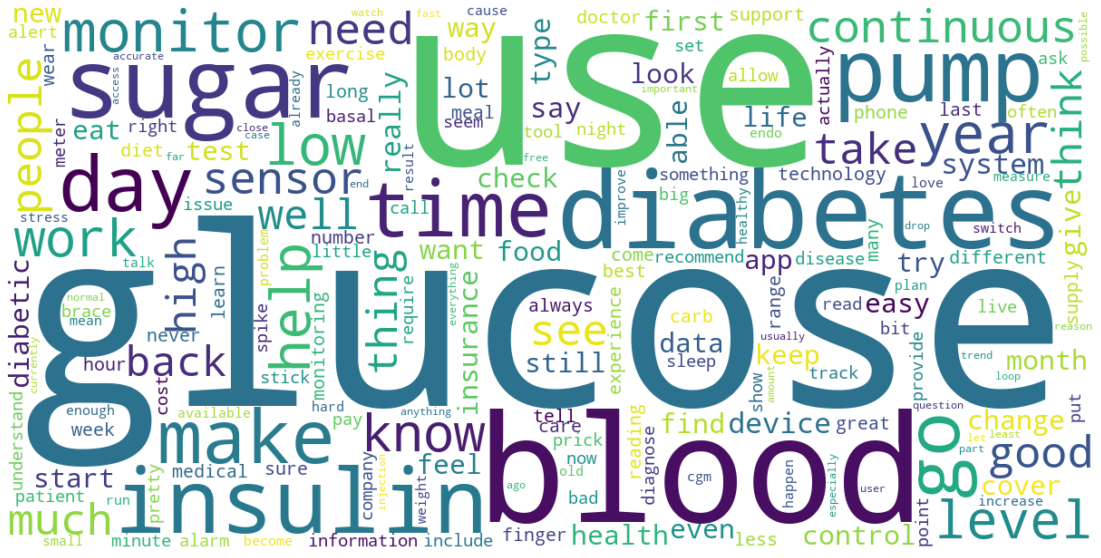

In [58]:
# words associated with positive connotations

benefits=data[data["plain_text"].str.match(r'^.*(?=(helped)|(helpful)|(benefitted)|(management)|(managing)|(benefit)|(valuable)|(reduce)|(manage))', na=False)]

benefits["plain_text"]=benefits.plain_text.str.replace("helped","")
benefits["plain_text"]=benefits.plain_text.str.replace("helpful","")
benefits["plain_text"]=benefits.plain_text.str.replace("benefitted","")
benefits["plain_text"]=benefits.plain_text.str.replace("management","")
benefits["plain_text"]=benefits.plain_text.str.replace("benefit","")
benefits["plain_text"]=benefits.plain_text.str.replace("managing","")
benefits["plain_text"]=benefits.plain_text.str.replace("manage","")
benefits["plain_text"]=benefits.plain_text.str.replace("valuable","")
benefits["plain_text"]=benefits.plain_text.str.replace("reduce","")

createWordCloud(', '.join(benefits.plain_text))

### c. What unmet needs do patients have related to CGMs (something patients want but are not getting)? 

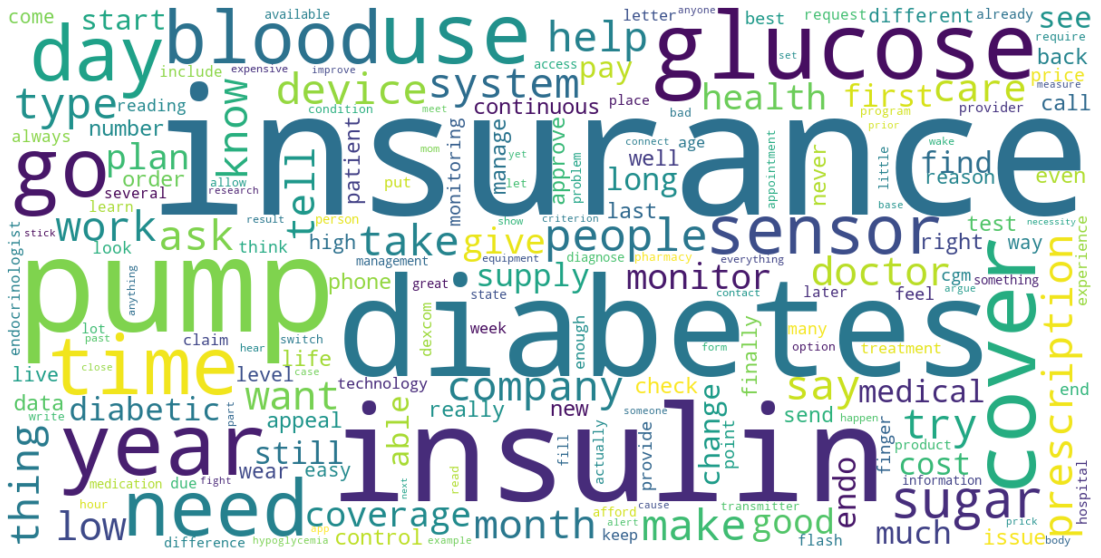

In [59]:
unmet_needs=data[data["plain_text"].str.match(r'^.*(?=(i wanted)|(i want)|(i wished)|(i wish)|(i needed)|(i need)|(i expected)|(i expect)|(denied)|(deny)|(denial))', na=False)]

unmet_needs["plain_text"]=unmet_needs.plain_text.str.replace("i wanted","")
unmet_needs["plain_text"]=unmet_needs.plain_text.str.replace("i want","")
unmet_needs["plain_text"]=unmet_needs.plain_text.str.replace("i wished","")
unmet_needs["plain_text"]=unmet_needs.plain_text.str.replace("i wish","")
unmet_needs["plain_text"]=unmet_needs.plain_text.str.replace("i needed","")
unmet_needs["plain_text"]=unmet_needs.plain_text.str.replace("i need","")
unmet_needs["plain_text"]=unmet_needs.plain_text.str.replace("i expected","")
unmet_needs["plain_text"]=unmet_needs.plain_text.str.replace("i expect","")
unmet_needs["plain_text"]=unmet_needs.plain_text.str.replace("denied","")
unmet_needs["plain_text"]=unmet_needs.plain_text.str.replace("deny","")
unmet_needs["plain_text"]=unmet_needs.plain_text.str.replace("denial","")


createWordCloud(', '.join(unmet_needs.plain_text))

# Q2.a What are praises & complaints and features of Dexcom & Freestyle Libre?

# Praises of Dexcom

In [72]:
dexcom_praises = []
dexcom_praises = dexcom_data[dexcom_data['vader_prediction'] == 'positive']['plain_text']
dexcom_praises

0        number great now ish care say want actual lab ...
1        try little side effect help insulin resistance...
3        lunch unit insulin pump chicken feta cheese ca...
5        new pancreas please dexcomwarrior diabetic fit...
7        impatiently wait tell get early happy hear fai...
                               ...                        
37818    even celebrate easter jewish harm do good less...
37825                                   dexcom look others
37829    use mix insulin take min eat get introduce pen...
37832    hear others experience vent incoming well cont...
37834    accurate first hour real pain start accuse low...
Name: plain_text, Length: 11969, dtype: object

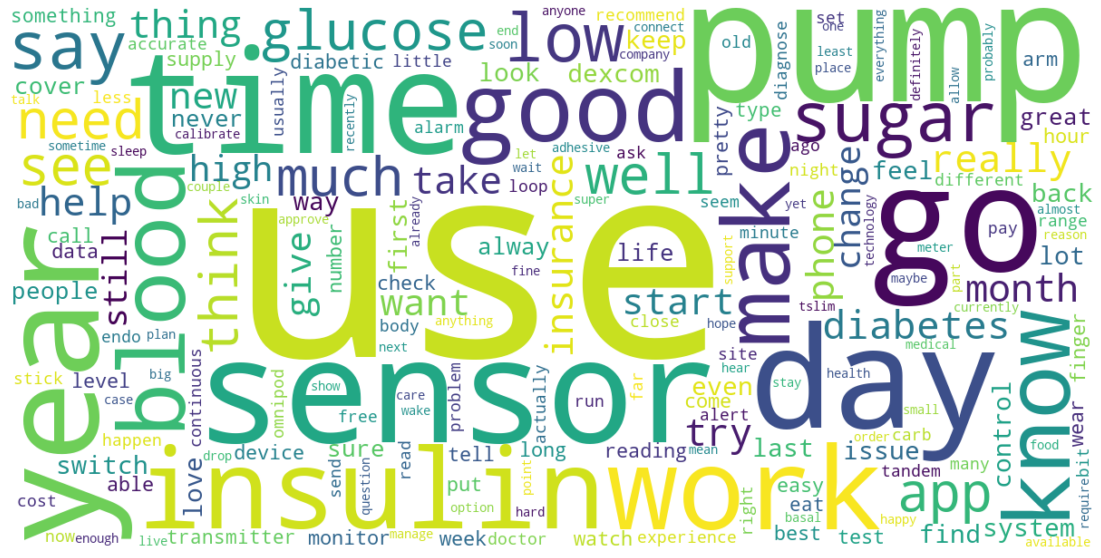

In [73]:
createWordCloud(', '.join(dexcom_praises))

# Complaints about Dexcom

In [74]:
dexcom_complaints = []
dexcom_complaints = dexcom_data[dexcom_data['vader_prediction'] == 'negative']['plain_text']
dexcom_complaints

2        run character also say newly diagnose idea fee...
9        pump usually number today get stick know even ...
24       exactly issue switch permission become availab...
25       get definitely help lot show fast bounce down ...
33       pump bad sensor legit forget wear thigh seriou...
                               ...                        
37812    bad box cartridge need go back pen needle prev...
37813    always show homescreen show live reading open ...
37836    day lately act weird spike drop point next lea...
37838    guess attribute light headedness low course ch...
37840    mom learn inject year old self orange nurse ti...
Name: plain_text, Length: 5415, dtype: object

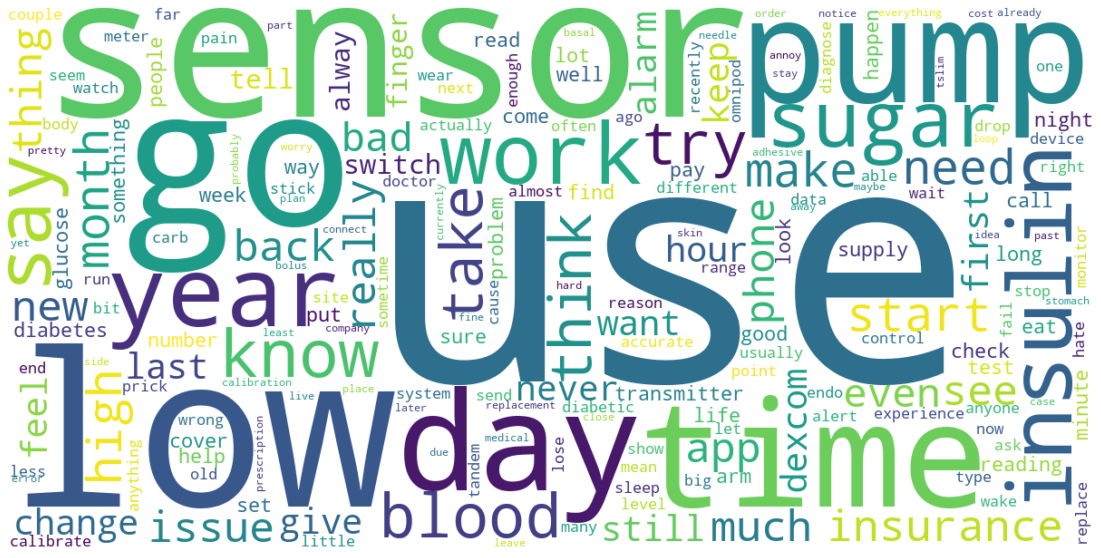

In [75]:
createWordCloud(', '.join(dexcom_complaints))

# Praises of Freestyle Libre

In [76]:
from collections import Counter

freestylelibre_praises = []
freestylelibre_praises = freestylelibre_data[freestylelibre_data['vader_prediction'] == 'positive']['plain_text']
print(freestylelibre_praises)

7        impatiently wait tell get early happy hear fai...
18       month fight insurance pharmacy move really exc...
23       man welcome club nobody want join highly highl...
36       use libre wife put mine back shoulder never re...
37                                      day sensor r thing
                               ...                        
37811    birthday sister turn year today good sister lo...
37814    like lot go proactive alert become rather impo...
37824    glad well type diabetes whatever say bad story...
37830    manage glucose level use sensor give life good...
37841    speak rep rep tell yet plan update app make co...
Name: plain_text, Length: 5192, dtype: object


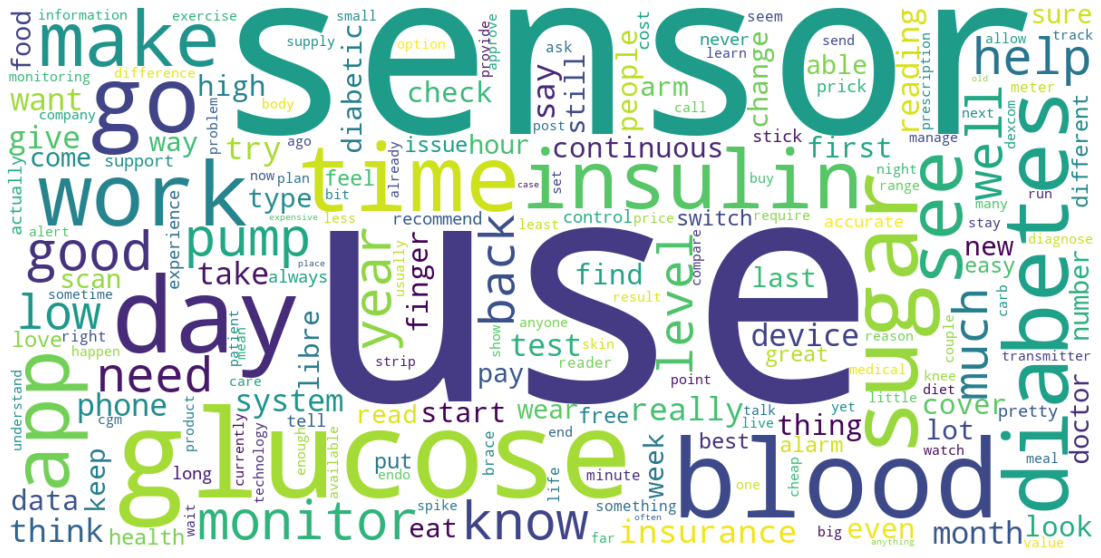

In [77]:
createWordCloud(', '.join(freestylelibre_praises))

# Complaints about Freestyle Libre

In [78]:
freestylelibre_complaints = []
freestylelibre_complaints = freestylelibre_data[freestylelibre_data['vader_prediction'] == 'negative']['plain_text']
freestylelibre_complaints

10       try get prescription expensive tell people get...
31       really worried sensor constant physical annoya...
45       ask get majority say best unfortunately find a...
69       use last couple year love find accurate first ...
74       everybody get diagnosis glucometer check blood...
                               ...                        
37761     unfortunately available shit country egypt stick
37768    buy continuous glucose monitor freestyle libre...
37798    mentally adjust calibrate finger stick first d...
37804    actually use sensor try switch life get sensor...
37806    chance be certify wait release regulatory cert...
Name: plain_text, Length: 1734, dtype: object

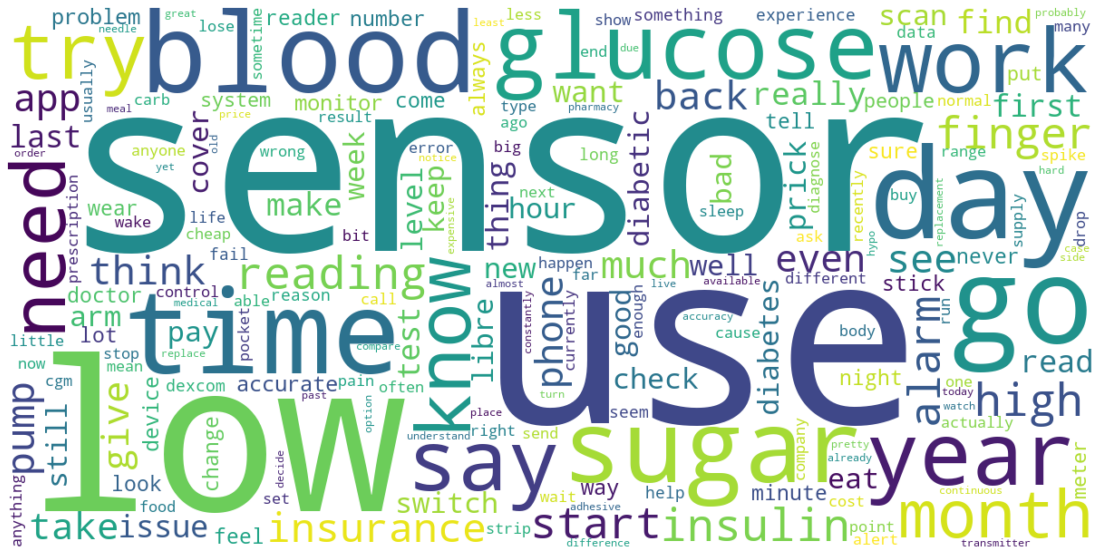

In [79]:
createWordCloud(', '.join(freestylelibre_complaints))

# Features talked about Dexcom

In [80]:
print(dexcom_data['phrases'])

0                        [ish care, actual lab look stuff]
1                        [side effect, insulin resistance]
2        [run character, diagnose idea, resource use om...
3        [lunch unit insulin pump chicken feta cheese c...
5        [new pancreas, dexcomwarrior diabetic fitness ...
                               ...                        
37835                   [able company, finger prick level]
37836    [act weird spike drop point, fuck hour, new work]
37837                                                   []
37838    [guess attribute, light headedness, low course...
37840    [old self, orange nurse time, human skin work,...
Name: phrases, Length: 19310, dtype: object


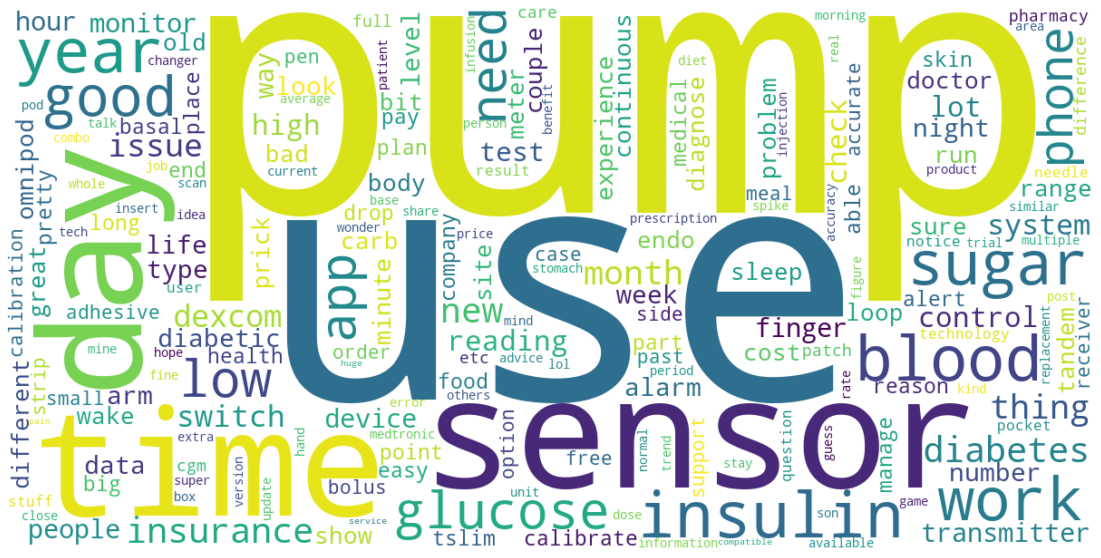

In [81]:
wordlist = []
for x in dexcom_data['phrases']:
    wordlist = x + wordlist

createWordCloud(', '.join(wordlist))

# Features talked about Freestyle Libre

In [82]:
print(freestylelibre_data['phrases'])

7        [accurate use past issue app good dexcoms lol ...
10       [prescribe physician, monitor sensor applicato...
18       [month fight insurance pharmacy, rid scan, ope...
23       [diabetic bible introduce thing insulin carb r...
31       [constant physical annoyance, pretty unobtrusi...
                               ...                        
37814                                                   []
37824                           [type diabetes, bad story]
37830    [manage glucose level use sensor, life good co...
37835                   [able company, finger prick level]
37841                           [rep rep, plan update app]
Name: phrases, Length: 7306, dtype: object


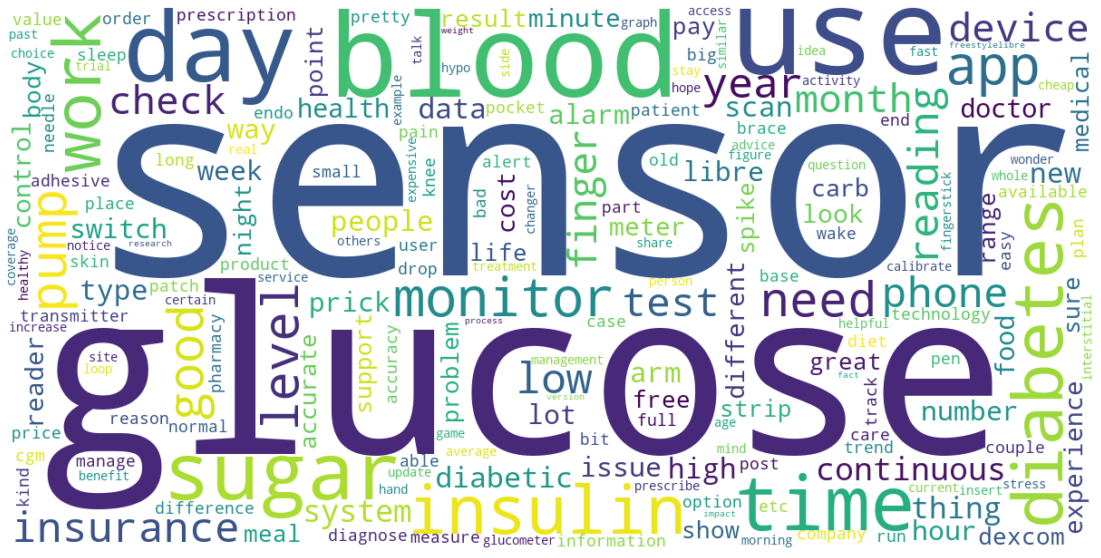

In [83]:
wordlist = []
for x in freestylelibre_data['phrases']:
    wordlist = x + wordlist

createWordCloud(', '.join(wordlist))

# 2.b Product features talked about

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=100, token_pattern='\w+|\$[\d\.]+|\S+')
# apply transformation
tf = vectorizer.fit_transform(data['plain_text']) #.toarray()
# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()
tf.shape

(36481, 1288)

In [85]:
from sklearn.decomposition import LatentDirichletAllocation
number_of_topics = 10
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=45) # random state for reproducibility
# Fit data to model
model.fit(tf)

LatentDirichletAllocation(random_state=45)

In [86]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

Topic 0 words Topic 0 weights Topic 1 words Topic 1 weights Topic 2 words  \
0           low          6518.4        sensor          5436.6           get   
1            go          3587.2           day          2927.1          year   
2           get          3082.5           use          2062.2         month   
3          high          2994.3           get          1267.9            go   
4          time          2510.4          time          1206.8          pump   
5         sugar          2363.0          last           945.4          week   
6       insulin          1754.1   transmitter           859.0           ago   
7         night          1737.0           new           849.3        switch   
8           eat          1707.7          work           840.5           use   
9          take          1678.9         issue           777.9         start   

  Topic 2 weights Topic 3 words Topic 3 weights Topic 4 words Topic 4 weights  \
0          4409.6           app          3437.6          pump          7077.9   
1          3885.4         phone          3328.0           get          4362.6   
2          1712.7           use          3204.4       insulin          2636.9   
3          1554.3          work          1461.7          make          2559.2   
4          1524.0         watch          1362.8        really          2128.3   
5          1364.9           get          1229.7          know          2072.7   
6          1302.7          data           850.5       control          1995.9   
7          1294.0        sensor           726.5          year          1989.2   
8          1211.4       connect           703.0          help          1987.8   
9          1210.5       reading           657.2         thing          1939.0   

  Topic 5 words Topic 5 weights Topic 6 words Topic 6 weights Topic 7 words  \
0         blood          6647.4           arm          2078.7        finger   
1         sugar          6088.9           use          1551.8          test   
2       glucose          6039.8          back          1292.5         prick   
3       monitor          3622.8           put          1210.2         stick   
4    continuous          2602.5          site          1166.7       reading   
5         level          2539.0          wear          1012.6         meter   
6           eat          1864.4         issue           872.1         blood   
7          food          1827.1        sensor           781.3           use   
8       insulin          1601.3            go           742.1           say   
9           see          1340.4           get           709.6           day   

  Topic 7 weights Topic 8 words Topic 8 weights Topic 9 words Topic 9 weights  
0          2735.7       glucose          2812.5     insurance          3917.8  
1          2170.2      diabetes          2384.8         cover          2542.2  
2          1333.8           use          2159.9           get          2277.1  
3          1328.7       insulin          1494.3        supply          2003.5  
4          1213.5        device          1198.6           pay          1978.3  
5          1212.0        system          1181.7       insulin          1761.0  
6          1110.9       monitor           988.7         month          1502.9  
7          1090.0    continuous           945.5          cost          1325.9  
8          1043.9        people           933.1          pump          1072.8  
9           984.1          also           731.2          need           991.3

In [91]:
for word in tf_feature_names:
    if word in relevant_keywords:
        tf_feature_names.remove(word)

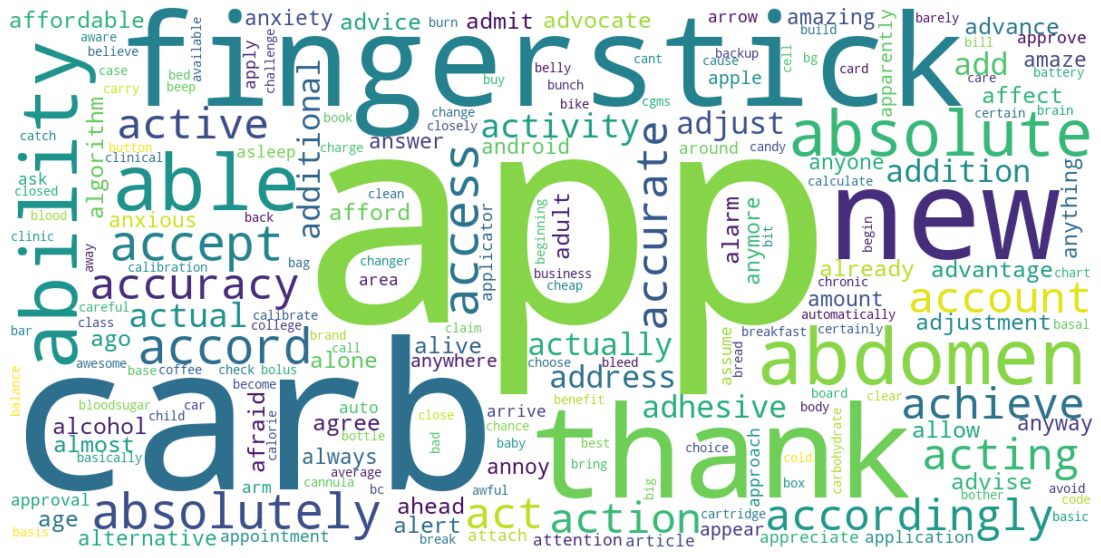

In [92]:
createWordCloud(', '.join(tf_feature_names))

# 2.c How do consumer opinions of Dexcom and Freestyle Libre compare?

In [62]:
dexcomPosReviewCount = len(dexcom_data[dexcom_data['vader_prediction'] == 'positive'])
dexcomNegReviewCount = len(dexcom_data[dexcom_data['vader_prediction'] == 'negative'])
dexcomNeuReviewCount = len(dexcom_data[dexcom_data['vader_prediction'] == 'neutral'])
librePosReviewCount = len(freestylelibre_data[freestylelibre_data['vader_prediction'] == 'positive'])
libreNegReviewCount = len(freestylelibre_data[freestylelibre_data['vader_prediction'] == 'negative'])
libreNeuReviewCount = len(freestylelibre_data[freestylelibre_data['vader_prediction'] == 'neutral'])

dexcomReviewCount = dexcomPosReviewCount + dexcomNegReviewCount + dexcomNeuReviewCount
libreReviewCount = librePosReviewCount + libreNegReviewCount + libreNeuReviewCount

if(dexcomReviewCount > libreReviewCount):
    print('Dexcom is more talked about than freestyle libre with {} more mentions in the posts'.format(dexcomReviewCount-libreReviewCount))
else:
    print('Freestyle libre is more talked about than dexcom with {} more mentions in the posts'.format(libreReviewCount-dexcomReviewCount))

sentimentbreakdowndata = pd.DataFrame({'type': ['dexcom', 'dexcom','dexcom', 'freestyle libre','freestyle libre','freestyle libre'], 'sentiment': ['positive','negative','neutral','positive','negative','neutral'],'count': [dexcomPosReviewCount,dexcomNegReviewCount,dexcomNeuReviewCount,librePosReviewCount,libreNegReviewCount,libreNeuReviewCount]})
sentimentbreakdowndata

Dexcom is more talked about than freestyle libre with 12004 more mentions in the posts


type sentiment  count
0           dexcom  positive  11969
1           dexcom  negative   5415
2           dexcom   neutral   1926
3  freestyle libre  positive   5192
4  freestyle libre  negative   1734
5  freestyle libre   neutral    380

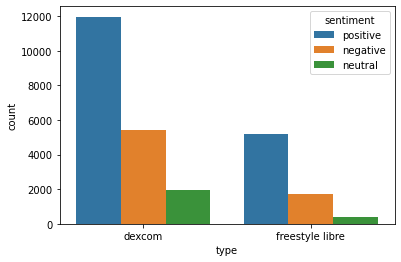

In [63]:
ax = sns.barplot(x='type', y='count',
                 hue='sentiment', data=sentimentbreakdowndata,
                 errwidth=0)

# Dexcom is more talked about than freestyle libre with 12004 more mentions in the posts
# As per the plot, Dexcom is being talked about more than Freestyle Libre
# As per the plot, Freestyle Libre has high percentage of positive mentions than Dexcom although the difference is small.
# Both products have high positive sentiments associated with them.

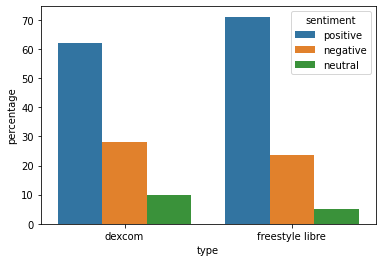

In [64]:
sentimentpercentdata = pd.DataFrame({'type': ['dexcom', 'dexcom','dexcom', 'freestyle libre','freestyle libre','freestyle libre'], 'sentiment': ['positive','negative','neutral','positive','negative','neutral'],'percentage': [dexcomPosReviewCount/dexcomReviewCount*100,dexcomNegReviewCount/dexcomReviewCount*100,dexcomNeuReviewCount/dexcomReviewCount*100,librePosReviewCount/libreReviewCount*100,libreNegReviewCount/libreReviewCount*100,libreNeuReviewCount/libreReviewCount*100]})

ax = sns.barplot(x='type', y='percentage',
                 hue='sentiment', data=sentimentpercentdata,
                 errwidth=0)

# As per the plot, overall sentiment regarding the two products is POSITIVE

# 2.e Based on your analysis, which one would you recommend?

# Based on our analysis, dexcom has huge mentions in the posts and although the relative positive sentiment of this product is a bit lower than that if freestyle libre but the count is considerably high.
# Getting such huge positive mentions is a big deal and so we recommend Dexcom product over Freestyle Libre

# 2.f What would you tell each of these brands to improve?

Dexcom: Since it is a widely used product, they need to focus on their quality and educating their user base. By quality, they should focus on improving their sensor, insulin pump. They should also make sure their product is more accessible, since as of this data time (2021), it was not available in many prominent countries like Netherlands, Egypt, etc. Also, a few users faced issues like it sounding an alarm for a normal range sugar, or an alarm for sugar lower than the target levels.

Freestyle Libre: Since their market penetration is low (assuming that it is low since less people are talking about them), they should focus on increasing their market share. With regards to their product, they also face problems in similar areas such as Dexcom, namely sensors. A lot of people complain that the sensor is annoying, giving a false reading, annoying them while sleeping, etc.

In [ ]:
for p in dexcom_complaints:
    print(p)

In [ ]:
for p in freestylelibre_complaints:
    print(p)